# Poisoned Samples

This notebook illustrates the poisoned samples with TeD and Trap-MID triggers, as presented at the Figure 4 in our paper: https://arxiv.org/abs/2411.08460.

In [ ]:
import sys

import torch
from torchvision.transforms import ToPILImage
from PIL import Image

sys.path.append("<PATH_TO_TRAP-MID_REPO>") # e.g., "../.."

import utils
import engine

`n_classes`: Number of triggers to be illustrated.

In [7]:
n_classes = 6
channel= 3
height = width = 64

## TeD Triggers

Each trapdoor trigger comprises five $(6 \times 6)$-pixel squares randomly scattered across the image, with a blend ratio $\alpha = 0.1$ or $0.2$. The intensity of each square was sampled from $\mathcal{N}(\mu, \sigma)$ with uniformly sampled $\mu \in [0, 1]$ and $\sigma \in [0, 1]$.

In [ ]:
ted_alpha = 0.1

patch_size = 6
n_patches = 5
pattern = torch.zeros((n_classes, channel, height, width))
ted_mask = torch.zeros((n_classes, channel, height, width))
for c in range(n_classes):
    for _ in range(n_patches):
        i = torch.randint(low=0, high=height-patch_size+1, size=(1,))[0]
        j = torch.randint(low=0, high=width-patch_size+1, size=(1,))[0]
        cur_mask = torch.zeros((channel, height, width))
        cur_mask[:, i:i+patch_size, j:j+patch_size] = 1

        mean = torch.rand((channel, height, width))
        std = torch.rand((channel, height, width))
        mean = torch.rand((channel, 1, 1))
        std = torch.rand((channel, 1, 1))
        patch = torch.randn((channel, height, width)) * std + mean
        patch *= cur_mask
        patch = patch.clamp(0, 1)

        pattern[c, :, :, :] += patch
        ted_mask[c, :, :, :] += cur_mask
ted_triggers = pattern.clamp(0, 1)
ted_mask = (ted_mask > 0).float()
ted_mask *= ted_alpha

## (Our) Trap-MID Triggers

Triggers were randomly initialized using a uniform distribution within $[0, 1]$, with a blend ratio $\alpha = 0.02$.

In [ ]:
trapmid_alpha = 0.02
trapmid_triggers = torch.rand((n_classes, channel, height, width))

## Visualization

Load 27018 images
Initializing data loader took 9s


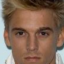

In [ ]:
file = "<PATH_TO_CONFIG_FILE>" # e.g., "../../config/celeba/classify_trap.json"
args = utils.load_json(json_file=file)
train_file = args['dataset']['train_file_path']
trainset, trainloader = utils.init_dataloader(args, train_file, mode="test")
sample = trainset[0][0]
ToPILImage()(sample)

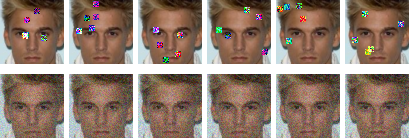

In [ ]:
scale = 10
n = 6
img = Image.new('RGB', (64*n + 5*(n-1), 128 + 10), 'white')
for i in range(n):
    img.paste(ToPILImage()(engine.blend(sample, ted_triggers[i], ted_mask[i] * scale)), ( (64+5)*i, 0))
    img.paste(ToPILImage()(engine.blend(sample, trapmid_triggers[i], trapmid_alpha * scale)), ((64+5)*i, 64+10))
img